In [1]:
from lib.imports import *

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
skip_idx = [19,24,26,32,34,38,40,45,52,55,70]
train_idx = range(71)
window_size = 101
X,y = load_and_window_nursing_list_for_convolution(train_idx,window_size=window_size)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,stratify=y)
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,test_size=.25,stratify=y_train)
trainloader = DataLoader(TensorDataset(X_train,y_train),batch_size=64,shuffle=True)
devloader = DataLoader(TensorDataset(X_dev,y_dev),batch_size=64,shuffle=True)
testloader = DataLoader(TensorDataset(X_test,y_test),batch_size=64,shuffle=True)

In [3]:
from torch import nn
device = 'cuda'
model = ResNet().to(device=device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

Params:  241729


100%|██████████| 17845/17845 [01:28<00:00, 201.39it/s]


tensor(0.0435)


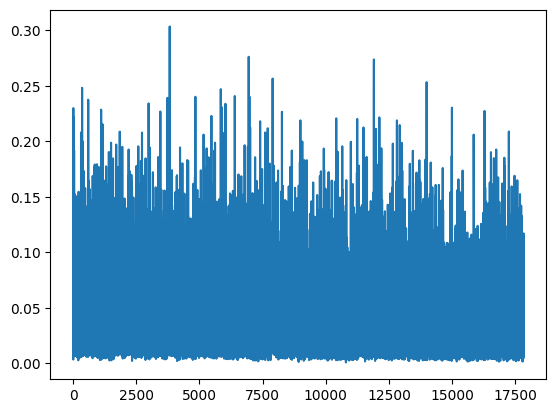

In [7]:
lossi = []
model.train()

for i in range(1):
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())

plt.plot(lossi)
print(torch.tensor(lossi).mean())

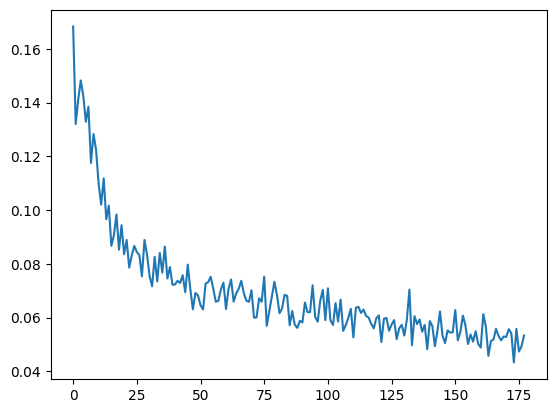

In [5]:
res = 100
plt.plot(torch.tensor(lossi)[:len(lossi)-len(lossi)%res].view(-1,res).mean(1))

In [ ]:
loss_tr = []
loss_dev = []
pbar = tqdm(range(10))

for epoch in pbar:
    # train loop
    model.train()
    loss_tr_total = 0
    for (X_tr,y_tr) in trainloader:
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tr_total += loss.item()
    loss_tr.append(loss_tr_total/len(trainloader))

    # dev loop
    model.eval()
    loss_dev_total = 0
    for (X_dv,y_dv) in devloader:
        X_dv,y_dv = X_dv.to(device),y_dv.to(device)
        logits = model(X_dv)
        loss = criterion(logits,y_dv)
        loss_dev_total += loss.item()
    loss_dev.append(loss_dev_total/len(devloader))

plt.plot(loss_tr,label='train')
plt.plot(loss_dev,label='dev')
plt.legend()

100%|██████████| 5949/5949 [00:09<00:00, 659.59it/s]


(0.0491933240735652,
 tensor([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]),
 tensor([[6.3518e-07],
         [2.1235e-04],
         [3.7877e-08],
         ...,
         [6.2653e-03],
         [7.9666e-03],
         [1.0867e-01]]))

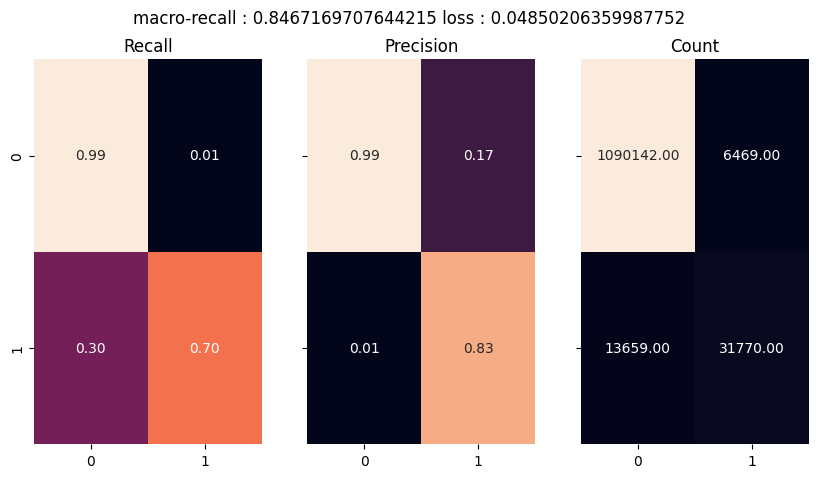

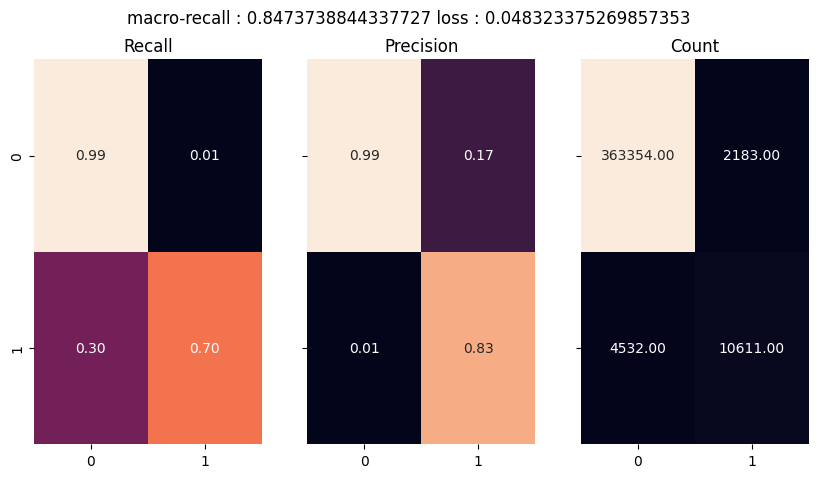

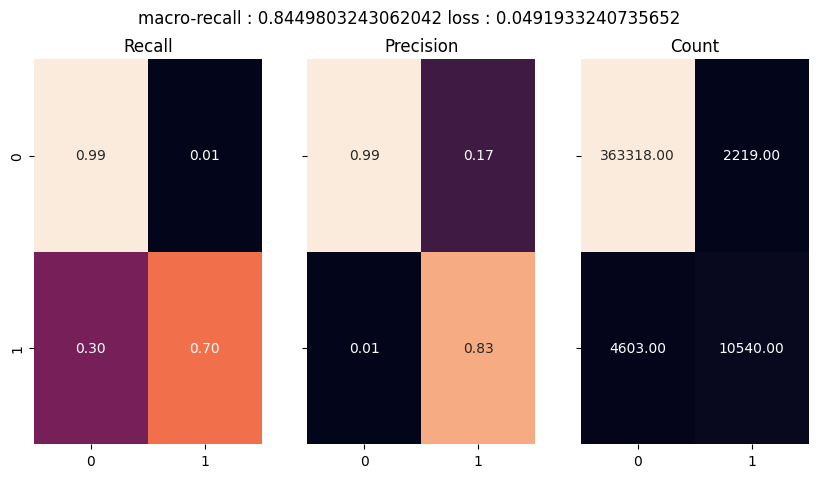

In [6]:
test_evaluation(trainloader,model,criterion)
test_evaluation(devloader,model,criterion)
test_evaluation(testloader,model,criterion)